In [1]:
#Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from ta import add_all_ta_features
from ta.utils import dropna

#Extracts data from the yahoo finance and gives us the latest data
import yfinance as yf

#Importing Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Importing feature selection libraries
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA


#Importing libraries for LSTMs and defining accuracy
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import accuracy_score, r2_score

import warnings
warnings.filterwarnings('ignore')

# Importing data and processing it using TA lib

In [2]:
#Returns X and y data in dataframe form processed and with TA lib features
#time is 10 years
def process_data(stock_name):
    start = datetime.datetime(2020,4,6)
    end = datetime.datetime(2022,4,6)
    stock = yf.download(stock_name,start,end)
    
    df = add_all_ta_features(
        stock, open="Open", high="High", low="Low", close="Close", volume="Volume")
    
    #Drops columns that have major null values
    
    df.drop(columns = ["trend_psar_up","trend_psar_down"], inplace = True)
    df.dropna(inplace = True)
    
    #Splits data into features and target values
    
    X = df.drop("Close",axis = 1)
    y = df["Close"]

    
    return X, y

# K- Feature Selector

In [3]:
#Defines k_best_selector which selects the best k features contributing to the target values
def K_best_selector(X, y):
    select = SelectKBest(f_regression, k = 25)
    select.fit_transform(X, y)
    cols = select.get_support(indices=True)
    #Keeping the columns that are most contributing from all the feature values
    X = X.iloc[:,cols]
    return X,y

# PCA features

In [4]:
def pca_selector(X, y):    
    
    #Splitting data for training and testing

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle = None)
    
    def get_variance(comp_count, train, test):
      pca = PCA(n_components=comp_count)
      train = pca.fit_transform(train)
      test = pca.transform(test)

      return pca.explained_variance_ratio_, train, test, pca

    components = 1
    explained_variance = 0
    while np.sum(explained_variance) < .95:

        explained_variance, X_train_fit, X_test_fit, pca = get_variance(components, X_train, X_test)

        components += 1

    # Reformats the principal components into a usable dictionary
    vals = np.array(pca.components_).T
    #print(vals)
    pc_lst = [f'PC{num+1}' for num in range(len(vals.T))]
    data = pd.DataFrame(vals, columns=pc_lst, index=X.columns)
    # Creates an empty dictionary to store feature importance
    feature_importance = {feature:0 for feature in X.columns}

    # Populates dictionary with their principal component correspondants
    for key in feature_importance.keys():
      feature_importance[key] = sum(data.loc[key])

    # Creates an ordered list of the importance values from the dictionary
    features_ordered = list(feature_importance.items())
    features_ordered = sorted(features_ordered, key = lambda x: x[1])[::-1]

    # Creates a list of bar heights and labels for each val above a threshold
    thresh  = 0.0001
    height = [val for name, val in features_ordered if val >= thresh]
    
    #Keeping the columns that are most contributing from all the feature values

    x = [name for name, val in features_ordered][:len(height)]
    X = X.loc[:,x]
    print(X)
    print(y)
    return X, y

# Making a model with all the layers and activation functions

In [5]:
#Defining the LSTM and adding layers to it
def make_model():
    model = Sequential()
    model.add(LSTM(units = 180, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 60, activation = 'relu',return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dense(units = 1))
    model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = "mae")
    
    return model

# Plotting function

In [6]:
#The plot function here plots the predicted values against the actual values and displays the figure
def plot_values(pred_vals, actual_vals):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(pred_vals)
    plt.plot(actual_vals)
    plt.show()
    plt.clf()

# Predictor function

Normalises data, feeds it into the model and gets prediction. Next, it plots the data using matplotlib

In [7]:
def create_model(X, y):
    
    #Defines the scaler for scaling down the data to values between 0 and 1. 
    scaler = MinMaxScaler()
    
    y = np.array(y)
    
    #Transforms the target data and feature data
        
    X_transformed = scaler.fit_transform(X)
    y_transformed = scaler.fit_transform(y.reshape(-1,1))
    
    #Splitting the data into training and testing
    
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.2, shuffle = None)
    
    train_len = len(X_train)
    test_len = len(X_test)
    
    X_train = np.array(X_train)
    X_train = X_train.reshape(train_len,-1,1)
    
    #Calls the make_model funtion that creates the sequential LSTM model
    predictor = make_model()
    
    #Trains the data on the new model with the training data for 10 epochs.
    predictor.fit(X_train, y_train, epochs = 10)
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(test_len,-1,1)
    y_test = np.reshape(y_test,(-1,1))
    
    #Here we calculate the predicted values using the trained data.
    
    y_pred = predictor.predict(X_test)
    
    #Inversing the transformed data to get the actual values matching to the real dataset
    
    y_pred_inv_transformed = scaler.inverse_transform(y_pred)
    y_actual_inv_transformed = scaler.inverse_transform(y_test)
    
    #Plotting the graph against the predicted values and real values
    plot_values(y_pred_inv_transformed, y_actual_inv_transformed)   
    
    #Calculating the r2 score to determine how accurate the model is.
    print("The r2 score of this prediction is : ", r2_score(y_actual_inv_transformed, y_pred_inv_transformed))

In [8]:
#Calls all the functions to predict the values defined after selecting the features using the kbest methid.
def final_kbest_func(name):
    X, y = process_data(name)
    new_X, new_y = K_best_selector(X, y)
    create_model(new_X, new_y)

In [9]:
#Calls all the functions to predict the values defined after selecting the features using the pca methid.
def final_pca_func(name):
    X, y = process_data(name)
    new_X, new_y = pca_selector(X, y)
    create_model(new_X, new_y)    

In [13]:
stocks =  ['AAPL','NVDA', 'UNH']

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 8s 77ms/step - loss: 0.1438 - mae: 0.3078
Epoch 2/10
11/11 [==============================] - 1s 88ms/step - loss: 0.0201 - mae: 0.1115
Epoch 3/10
11/11 [==============================] - 1s 118ms/step - loss: 0.0106 - mae: 0.0856
Epoch 4/10
11/11 [==============================] - 1s 119ms/step - loss: 0.0047 - mae: 0.0517
Epoch 5/10
11/11 [==============================] - 1s 117ms/step - loss: 0.0042 - mae: 0.0502
Epoch 6/10
11/11 [==============================] - 1s 117ms/step - loss: 0.0043 - mae: 0.0528
Epoch 7/10
11/11 [==============================] - 1s 124ms/step - loss: 0.0033 - mae: 0.0462
Epoch 8/10
11/11 [==============================] - 1s 118ms/step - loss: 0.0034 - mae: 0.0464
Epoch 9/10
11/11 [==============================] - 1s 120ms/step - loss: 0.0036 - mae: 0.0475
Epoch 10/10
11/11 [==============================] - 1s 120ms/step - loss: 0.0

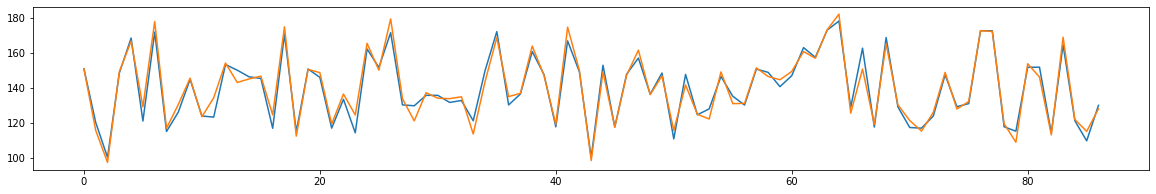

The r2 score of this prediction is :  0.9562082818593026
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 11s 115ms/step - loss: 0.1196 - mae: 0.2564
Epoch 2/10
11/11 [==============================] - 1s 113ms/step - loss: 0.0281 - mae: 0.1442
Epoch 3/10
11/11 [==============================] - 1s 113ms/step - loss: 0.0080 - mae: 0.0721
Epoch 4/10
11/11 [==============================] - 1s 114ms/step - loss: 0.0051 - mae: 0.0507
Epoch 5/10
11/11 [==============================] - 1s 113ms/step - loss: 0.0033 - mae: 0.0407
Epoch 6/10
11/11 [==============================] - 1s 116ms/step - loss: 0.0029 - mae: 0.0378
Epoch 7/10
11/11 [==============================] - 1s 116ms/step - loss: 0.0029 - mae: 0.0377
Epoch 8/10
11/11 [==============================] - 1s 116ms/step - loss: 0.0025 - mae: 0.0353
Epoch 9/10
11/11 [==============================] - 1s 113ms/step - loss: 0.0027 - mae: 0.0364
Epoch 10/10
11/11 

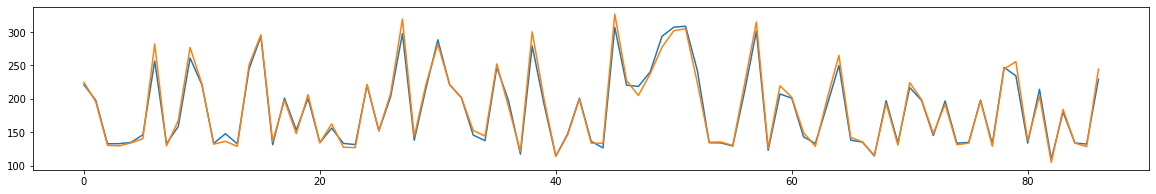

The r2 score of this prediction is :  0.9801766665524948
[*********************100%***********************]  1 of 1 completed
Epoch 1/10
11/11 [==============================] - 11s 117ms/step - loss: 0.1394 - mae: 0.2883
Epoch 2/10
11/11 [==============================] - 1s 115ms/step - loss: 0.0192 - mae: 0.1162
Epoch 3/10
11/11 [==============================] - 1s 109ms/step - loss: 0.0072 - mae: 0.0702
Epoch 4/10
11/11 [==============================] - 1s 115ms/step - loss: 0.0039 - mae: 0.0498
Epoch 5/10
11/11 [==============================] - 1s 93ms/step - loss: 0.0030 - mae: 0.0432
Epoch 6/10
11/11 [==============================] - 1s 98ms/step - loss: 0.0028 - mae: 0.0414
Epoch 7/10
11/11 [==============================] - 1s 102ms/step - loss: 0.0025 - mae: 0.0391
Epoch 8/10
11/11 [==============================] - 1s 98ms/step - loss: 0.0022 - mae: 0.0381
Epoch 9/10
11/11 [==============================] - 1s 101ms/step - loss: 0.0024 - mae: 0.0385
Epoch 10/10
11/11 [==

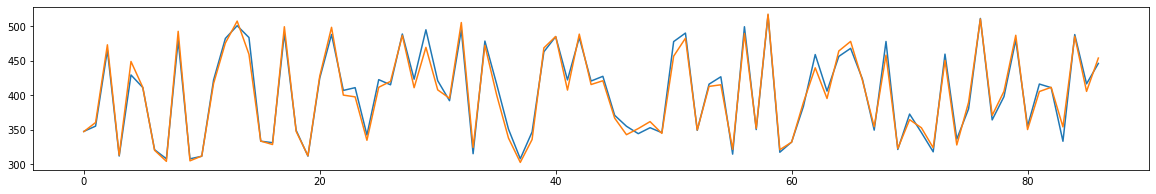

The r2 score of this prediction is :  0.9775714819061772


<Figure size 1440x216 with 0 Axes>

In [14]:
for i in stocks:
    final_kbest_func(i)